In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.nn import BCEWithLogitsLoss, MSELoss
from transformers import RobertaTokenizerFast, RobertaConfig, RobertaModel, RobertaForSequenceClassification, get_linear_schedule_with_warmup
import json
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from model import Model
import time

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
tokenizer = RobertaTokenizerFast.from_pretrained("microsoft/codebert-base", do_lower_case=True)

config = RobertaConfig.from_pretrained("microsoft/codebert-base")
config.num_labels = 1
model = RobertaForSequenceClassification.from_pretrained("microsoft/codebert-base", config=config)
model.to(device)
#model = Model(model)
#model.to(device)

Some weights of the model checkpoint at microsoft/codebert-base were not used when initializing RobertaForSequenceClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at microsoft/codebert-base and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be 

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
             

In [ ]:
tokens = ["<type>", "<specifier>", "<decl>", "<parameter_list>", "<decl_stmt>", "<comment>", "<directive>", "<parameter_list>", "<expr_stmt>", "<control>", "<argument_list>", "<parameter>", "<index>",
          "<argument>", "<default>", "<call>", "<then>", "<label>", "<ternary>", "<condition>", "<init>"]
tokenizer.add_tokens(tokens)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
import dataset.optimize_data as rename
tokenizer.add_tokens(rename.keywords)
tokenizer.add_tokens(rename.standard_lib_funcs)
model.resize_token_embeddings(len(tokenizer))

In [ ]:
high_freq_words = ['avctx','goto','uintt','sizeof','uint8t','avlog','codec','intt','\\n\\t','AVLOGERROR','\\n','pkt','dst','errp','opaque','arg1','channels','bufsize','ifdef','AVERROR','fprintf','linesize','samples','sps','d\\n','cpuenv','stderr','opcode','cpuR','arg2','opts','AVERRORINVALIDDATA','stride','getbits','t1','t0','avpkt','cpuT0','geterrno','memcpy','codecid','privdata','vdev','memset','pts','strcmp','ENOMEM','packet','AVCodecContext','0x','mbx','tcgtempfree','cpuir','localerr','gfree','streams','timebase','samplerate','TCGv','getbits1','idx','EINVAL','arg3','mbtype','modrm','movq','mv','amlappend','spapr','mby','tempblock','tb','regs','mm0','pixfmt','FIXME','qemu','errorsetg','bitrate','s\\n','scan8','DPRINTF','codectype','BlockDriverState','targetulong','irq','TCGvi','errorreport','0xff','extradata','acb','streamindex','avfreep','0xf','hci','mm1','blk','AVFrame','predictor','ramsize','cpumodel','avfree','pcstart','picttype','datasize','nbsectors','qxl','AVFormatContext','0x00','alac','CPUState','sizet','invalid','strlen','snprintf','REGa','framesize','chr','avmallocz','qiov','errno','t2','RRRS','mm2','xfer','tcgtempnew','aviorb','s\'','nbstreams','memidx','pfl','kernelfilename','nbsamples','entries','AVNOPTSVALUE','tcgtempfreei','cpuA0','qdev','AVPacket','saddr','src2','tcgtempnewi','sectornum','dinfo','retval','RRRT','putbits','hdr','tmpz','csbase','insn','i8','gmalloc0','mm3','targetphysaddrt','efault','qemuirq','refcount','INTMAX','EIO','AVLOGDEBUG','AVRL','src1','tmp1','unlockuser','RRRR','tcggenmovii','unimplemented','Rn','AVLOGWARNING','fmt','motionval','cnt','FFMIN','mm4','xen9pdev','fdt','tcgconsti','xendev','exceptionindex','AVStream','timestamp','islit','avmalloc','MemoryRegion','putuser','cputmp2i','0x80','currentpictureptr','op1','mbheight','cputobe','dstFormat','illegalop','mbwidth']
tokenizer.add_tokens(high_freq_words)
model.resize_token_embeddings(len(tokenizer))

In [5]:
max_length = 512

def convert_examples_to_features(js):
    code=' '.join(js['func'].split())
    inputs = tokenizer(
        code, 
        max_length=max_length, 
        return_tensors="pt",
        padding="max_length",
        truncation=True
    )
    return inputs, js['target']

def convert_examples_to_features2(js):
    code=' '.join(js['func'].split())
    code_tokens = tokenizer.tokenize(code, return_tensors="pt", max_length=510, padding="max_length")
    token_count = len(code_tokens)
    code_tokens = code_tokens[:510]
    source_tokens =[tokenizer.cls_token]+code_tokens+[tokenizer.sep_token]
    source_ids =  tokenizer.convert_tokens_to_ids(source_tokens)
    source_ids = torch.tensor(source_ids)
    return {"input_ids": source_ids, "attention_mask": source_ids.ne(1)}, js['target'], token_count

class CustomDataset(Dataset):
    def __init__(self, file_path, skip):
        self.examples = []
        with open(file_path) as f:
            for line in f:
                js=json.loads(line.strip())
                input, target, token_count = convert_examples_to_features2(js)
                if token_count > 800 and skip:
                    continue
                self.examples.append([input, target])

    def __len__(self):
        return len(self.examples)

    def __getitem__(self, i):       
        return self.examples[i][0], self.examples[i][1]

In [6]:
train_dataset = CustomDataset('dataset/train_renamed.jsonl', True)
len(train_dataset)

17954

In [7]:
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, pin_memory=True, shuffle=True)

In [8]:
test_dataset = CustomDataset('dataset/test_renamed.jsonl', False)
batch_size = 4
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, pin_memory=True, shuffle=False)
len(test_dataset)

2732

In [9]:
adam_epsilon = 1e-8
learning_rate = 2e-5
max_grad_norm = 1.0
weight_decay = 0.00
no_decay = ['bias', 'LayerNorm.weight']
epochs = 5
max_steps = epochs * len(train_dataloader)
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': weight_decay},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate, eps=adam_epsilon)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=max_steps * 0.1, num_training_steps=max_steps)

In [10]:
update_loss_steps = 100

In [11]:
stats = []
for i, epoch in enumerate(range(epochs)):
    #TRAINING
    bar = tqdm(train_dataloader,total=len(train_dataloader))
    bar.set_description(f"Epoch {epoch}")
    model.train()
    total_loss = 0
    val_results = []
    val_labels = []
    for step, batch in enumerate(bar):
        inputs = batch[0]
        inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
        labels = batch[1].to(device)
        ids, mask = inputs['input_ids'], inputs['attention_mask']
        #outputs = model(**inputs)
        outputs = model(ids, mask)
        #result = outputs[:,0]
        result = outputs.logits[:,0]
        loss = BCEWithLogitsLoss()(result, labels.float())
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()
        optimizer.zero_grad()
        scheduler.step()
        total_loss += loss.mean().item()
        val_results.append(result.cpu().detach().numpy())
        val_labels.append(labels.cpu().numpy())
        if step % update_loss_steps == 99:
            results=np.concatenate(val_results,0)
            labels=np.concatenate(val_labels,0)
            preds=results>0.5
            eval_acc=np.mean(labels==preds)
            loss = total_loss / step
            stats.append({'steps': (epoch*len(train_dataloader))+step, 'loss': loss, 'acc': eval_acc})
            bar.set_description(f"Epoch {epoch}: loss {loss:.4f}, acc {eval_acc:.4f}")
    
    #EVAL
    model.eval()
    with torch.no_grad():
        bar = tqdm(test_dataloader,total=len(test_dataloader))
        total_loss = 0
        val_results = []
        val_labels = []
        for step, batch in enumerate(bar):
            inputs = batch[0]
            inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
            labels = batch[1].to(device)
            ids, mask = inputs['input_ids'], inputs['attention_mask']
            #outputs = model(**inputs)
            outputs = model(ids, mask)
            #result = outputs[:,0]
            result = outputs.logits[:,0]
            loss = BCEWithLogitsLoss()(result, labels.float())
            total_loss += loss.mean().item()
            val_results.append(result.cpu().detach().numpy())
            val_labels.append(labels.cpu().numpy())
    results=np.concatenate(val_results,0)
    labels=np.concatenate(val_labels,0)
    preds=results>0.5
    eval_acc=np.mean(labels==preds)
    loss = total_loss / step
    time.sleep(1)
    print(f"Test set: loss {loss:.4f}, acc {eval_acc:.4f}")
    model.save_pretrained('Limit800/epoch'+str(epoch))

100%|██████████| 683/683 [00:41<00:00, 16.62it/s]


Test set: loss 0.6570, acc 0.5864


100%|██████████| 683/683 [00:41<00:00, 16.63it/s]


Test set: loss 0.6335, acc 0.6138


100%|██████████| 683/683 [00:40<00:00, 16.80it/s]


Test set: loss 0.6515, acc 0.6464


100%|██████████| 683/683 [00:40<00:00, 16.80it/s]


Test set: loss 1.0327, acc 0.6409


100%|██████████| 683/683 [00:40<00:00, 16.79it/s]


Test set: loss 1.3143, acc 0.6376


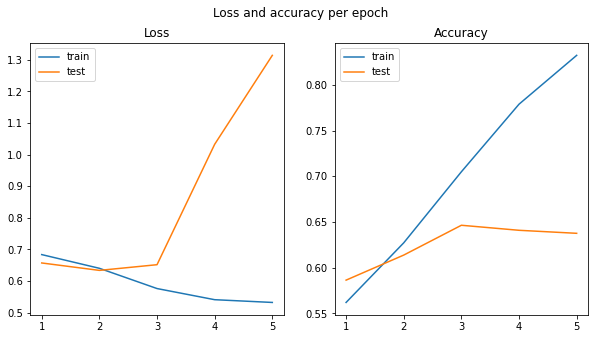

In [22]:
train_losses = [0.6835, 0.6401, 0.5760, 0.5407, 0.5320]
test_losses = [0.6570, 0.6335, 0.6515, 1.0327, 1.3143]
train_accs = [0.5620, 0.6272, 0.7049, 0.7788, 0.8322]
test_accs = [0.5864, 0.6138, 0.6464, 0.6409, 0.6376]

epochs = list(range(1, len(train_losses) + 1))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
fig.suptitle('Loss and accuracy per epoch')
ax1.plot(epochs, train_losses, label='train')
ax1.plot(epochs, test_losses, label='test')
ax1.legend()
ax1.set_title('Loss')
ax2.plot(epochs, train_accs, label='train')
ax2.plot(epochs, test_accs, label='test')
ax2.legend()
ax2.set_title('Accuracy')
#plt.show()
plt.savefig('lossacc.png', dpi=500)

In [ ]:
plt.plot([s['steps'] for s in stats], [s['loss'] for s in stats])
plt.plot([s['steps'] for s in stats], [s['acc'] for s in stats])
plt.legend(['loss', 'acc'])
plt.show()

In [ ]:
model = RobertaForSequenceClassification.from_pretrained("Limit800/epoch4", config=config)
model.to(device)
pass

In [ ]:
config = RobertaConfig.from_pretrained("microsoft/codebert-base")
config.num_labels = 1
model = RobertaForSequenceClassification.from_pretrained("Limit800/epoch2", config=config)
model.to(device)
#model = Model(model)
#model.to(device)

model.eval()
with torch.no_grad():
    bar = tqdm(test_dataloader,total=len(test_dataloader))
    total_loss = 0
    val_results = []
    val_labels = []
    for step, batch in enumerate(bar):
        inputs = batch[0]
        inputs = {key: value.squeeze(1).to(device) for key, value in inputs.items()}
        labels = batch[1].to(device)
        ids, mask = inputs['input_ids'], inputs['attention_mask']
        #outputs = model(**inputs)
        outputs = model(ids, mask)
        #result = outputs[:,0]
        result = outputs.logits[:,0]
        loss = BCEWithLogitsLoss()(result, labels.float())
        total_loss += loss.mean().item()
        val_results.append(result.cpu().detach().numpy())
        val_labels.append(labels.cpu().numpy())
results=np.concatenate(val_results,0)
labels=np.concatenate(val_labels,0)
preds=results>0.5
eval_acc=np.mean(labels==preds)
loss = total_loss / step
time.sleep(1)
print(f"loss {loss:.4f}, acc {eval_acc:.4f}")